In [1]:
import os
import time
import pickle
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import special, integrate, optimize, stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gaussian_preact
from gaussian_preact import find_density, find_activation, ParameterizedFunction, Integrand, ActivationFunction, ActivationFunctionTraining
from gaussian_preact.post_process import build_color, build_label, build_linestyle

torch.set_default_dtype(torch.float64)

plt.rcParams['text.usetex'] = 'True'
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [9]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]
path_objects = './objects/'

#lst_theta = [2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]    # extensive
lst_theta = [2.05, 2.50, 3.00, 4.00, 5.00, 7.00, 10.00]    # as in the paper
#lst_theta = [2.11]    # for testing

# Compute an approximation $g_{\Lambda}$ of the density $f_{|Y|}$

In this section, we compute an approximation $g_{\Lambda}$ of the desired density function $f_{|Y|}$. The approximation we compute is a function with parameters, which should be optimized. 

The key step is the computation of the integral: $F_{\Lambda}(z) = \int_0^{\infty} S_W(z/x) g_{\Lambda}(x) \mathrm{d}x$, in such a way that $F_{\Lambda}(z)$ can be automatically differentiated by PyTorch according to the parameters of $g_{\Lambda}$. See the documentation of `gaussian_preact.integration` for more information.

In [3]:
# Set the initial parameters of the density
theta = None
lambd = 1.
alpha = 3.
lambd_1 = 1.
lambd_2 = 1.
gamma = 1.

# Build the dataset
zmin = 0
zmax = 5
znum = 200
inputs = torch.linspace(zmin, zmax, znum)
targets = gaussian_preact.surv_Gaussian_abs(inputs)

In [4]:
# Optimization parameters
lr = .01
epochs = 600

In [5]:
# Initialize storage dicts
dct_densities = {}
dct_losses = {}

In [6]:
# Compute the densities for each theta
for theta in lst_theta:
    # Initialize objects depending on theta
    theta_conj = theta_conj = 1/(1/2 - 1/theta)
    surv_kernel_Weib = gaussian_preact.build_surv_kernel_Weib(theta, lambd)
    density = ParameterizedFunction(theta, theta_conj, alpha, lambd_1, lambd_2, gamma)
    integrand = Integrand(density, surv_kernel_Weib)
    
    # Train and get the final density
    dct_densities[theta], dct_losses[theta] = find_density(theta, surv_kernel_Weib, density, integrand,
            inputs, targets, lr = lr, epochs = epochs, scipy_update_period = 50, theta_conj_phases = 2)

In [7]:
# Store the densities
for theta in lst_theta:
    density = dct_densities[theta]
    loss = dct_losses[theta]
    pickle.dump({'density': density, 'loss': loss}, \
        file = open(path_objects + 'DensityFunc_theta-{:.2f}.pkl'.format(theta), 'wb'))

(-0.1, 1.1)

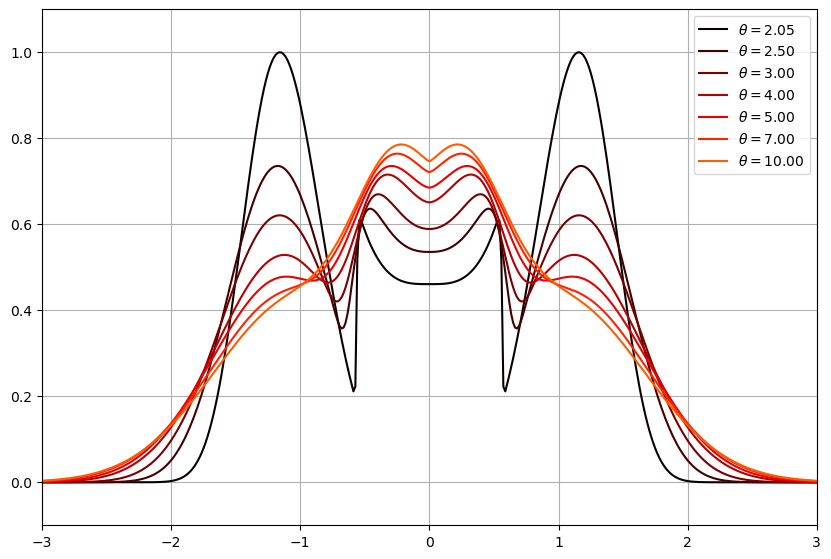

In [7]:
# Plot the densities
tens_x = torch.linspace(0, 3, 200)
with torch.no_grad():
    for theta, density in dct_densities.items():
        tens_y = density(tens_x)
        sym_tens_x = torch.concat((-tens_x.flip(0), tens_x))
        sym_tens_y = torch.concat((tens_y.flip(0), tens_y))
        
        plt.plot(sym_tens_x, sym_tens_y, label = r'$\theta = {:.2f}$'.format(theta), 
                 c = build_color({'act_function': 'weibull', 'act_theta': theta}))
        
plt.legend()
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-.1, 1.1)

# Compute an interpolation of the activation function $\phi_{\theta}$

Now that we have computed an estimation of $f_{|Y|}$, we are able to compute numerically $\phi_{\theta}$ at any point.

In this section, we compute it at `xnum = 400` points between $0$ and `xmax = 10`. As a result, we can build an interpolation of $\phi_{\theta}$.

In [6]:
# Load the densities
dct_densities = {}
for theta in lst_theta:
    dct_load = pickle.load(open(path_objects + 'DensityFunc_theta-{:.2f}.pkl'.format(theta), 'rb'))
    dct_densities[theta] = dct_load['density']

In [8]:
def build_density_no_torch(density):
    def density_no_torch(x):
        with torch.no_grad():
            return density(x)
        
    return density_no_torch

In [9]:
# Interpolation parameters
xmax = 10
xnum = 400
inputs = torch.linspace(0, xmax, xnum)

In [10]:
# Initialize storage dicts
dct_act_interpolation_x = {}
dct_act_interpolation_y = {}

In [15]:
for theta in lst_theta:
    # Build the density function without autograd (improves the computation speed)
    density = build_density_no_torch(dct_densities[theta])
    
    # Compute an interpolation of the related activation function
    act_interpolation = torch.empty_like(inputs)
    for i, x in enumerate(inputs):
        y = 2 * stats.norm.sf(x)
        act_interpolation[i] = optimize.brentq(lambda t: integrate.quad(density, t, np.inf)[0] - y, 0, 100)

    act_interpolation[0] = 0
    
    # Store the result
    dct_act_interpolation_x[theta] = inputs
    dct_act_interpolation_y[theta] = act_interpolation

In [16]:
# Store the interpolations
for theta in lst_theta:
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    pickle.dump({'act_interpolation_x': act_inter_x, 'act_interpolation_y': act_inter_y}, \
        file = open(path_objects + 'ActInterpolation_theta-{:.2f}.pkl'.format(theta), 'wb'))

(-10.0, 10.0)

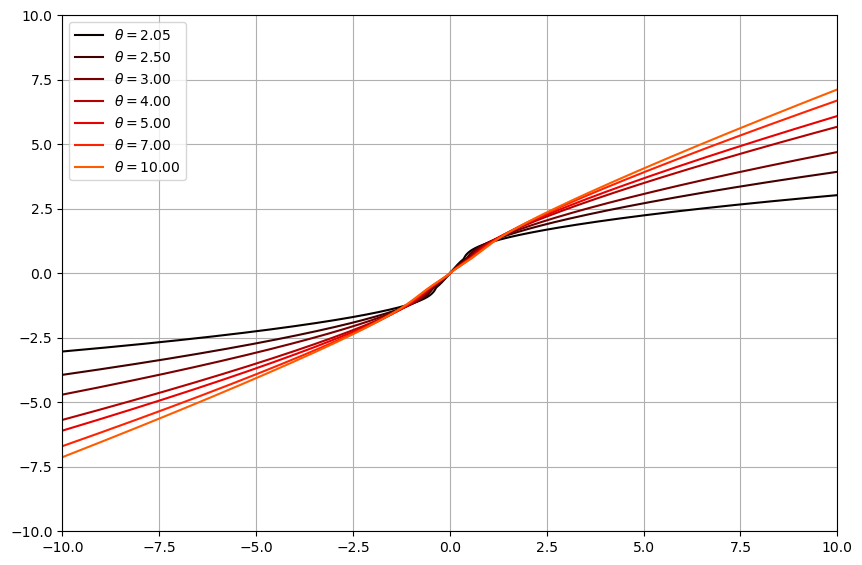

In [12]:
# Plot the interpolations
for theta in lst_theta:
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    sym_tens_x = torch.concat((-act_inter_x.flip(0), act_inter_x))
    sym_tens_y = torch.concat((-act_inter_y.flip(0), act_inter_y))
    plt.plot(sym_tens_x, sym_tens_y, label = r'$\theta = {:.2f}$'.format(theta), 
             c = build_color({'act_function': 'weibull', 'act_theta': theta}))
    
plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)

(-3.0, 3.0)

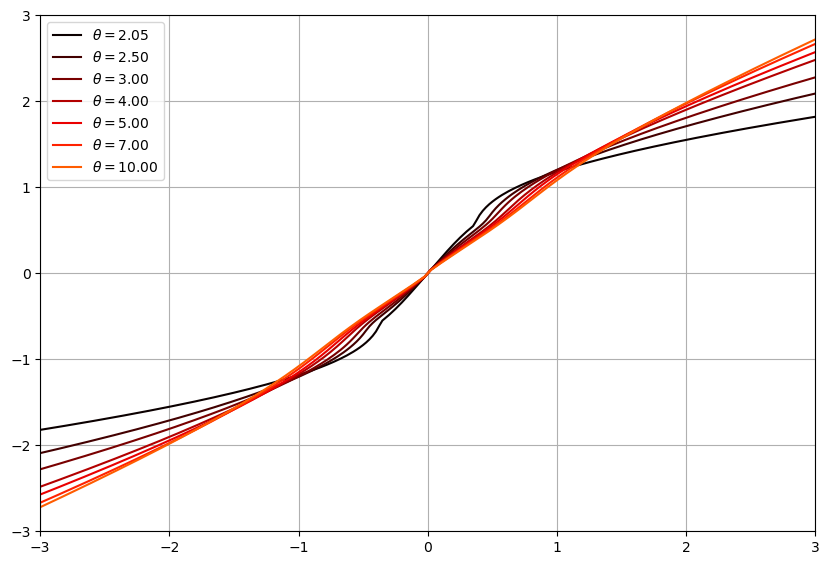

In [13]:
# Plot the interpolations
for theta in lst_theta:
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    sym_tens_x = torch.concat((-act_inter_x.flip(0), act_inter_x))
    sym_tens_y = torch.concat((-act_inter_y.flip(0), act_inter_y))
    plt.plot(sym_tens_x, sym_tens_y, label = r'$\theta = {:.2f}$'.format(theta), 
             c = build_color({'act_function': 'weibull', 'act_theta': theta}))
    
plt.legend()
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Find an approximation of $\phi_{\theta}$ that is computationally efficient

The interpolation we have build is not fully satisfying if we want to use it in pytorch modules. For instance, computing it at a specific point $x$ needs to determine in each interval of the interpolation $x$ lies. This kind of operation slows down the computation, while making it more difficult to parallelize.

So, we have made the choice to approximate it by a parameterized function $\tilde{\phi}_{\theta}$. The parameters of this function are optimized in such a way that $\tilde{\phi}_{\theta}$ is the closest possible to the interpolation computed in the preceding section.

The family of functions has been chosen based on the shape of the interpolations, and the theoretic asymptotic growth rate, which is roughly $x^{1 - 2/\theta}$.

In [3]:
# Load the interpolations
dct_act_interpolation_x = {}
dct_act_interpolation_y = {}
for theta in lst_theta:
    dct_load = pickle.load(open(path_objects + 'ActInterpolation_theta-{:.2f}.pkl'.format(theta), 'rb'))
    dct_act_interpolation_x[theta] = dct_load['act_interpolation_x']
    dct_act_interpolation_y[theta] = dct_load['act_interpolation_y']

In [4]:
# Set the initial parameters of the activation function
a = 1
b = 1
c = 1
d = .01

f = 1
g = .01

# Build the inputs
"""
In the context of Gaussian pre-activations, we must ensure that our proposition of activation function
fits well the interpolation where the Normal(0, 1) is concentrated. This is why we build 'inputs_gauss'.

However, the set 'inputs_gauss' is highly concentrated around 0, and it would not impose any constraint,
for instance, on the interval [4, 10]. So, we artificially add some points to 'inputs_gauss' to build
the new set 'inputs', which covers the interval [-xmax, xmax] (where xmax can be set to 10).
"""
xnum_gauss = 1000
inputs_gauss = torch.tensor(np.sqrt(2) * special.erfinv(np.linspace(-1 + 1/xnum_gauss, 1 - 1/xnum_gauss, 
                                                                    2*xnum_gauss - 1)))
xmax = 10
xnum_compl = 50
inputs = torch.concat((torch.linspace(-xmax, inputs_gauss[0], xnum_compl),
                       inputs_gauss,
                       torch.linspace(inputs_gauss[-1], xmax, xnum_compl)))

In [5]:
# Optimization parameters
lr = .01
epochs = 10000

In [6]:
# Initialize storage dicts
dct_activations = {}
dct_errors = {}

In [7]:
# Compute the activation function for each theta
for theta in lst_theta:
    # Get the interpolation
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    
    # Initialize the activation function to train
    activation = ActivationFunctionTraining(theta, a, b, c, d, f, g)
    
    # Perform the training
    activation, error = find_activation(theta, activation, act_inter_x, act_inter_y, inputs,
            lr = lr, epochs = epochs)
    
    dct_activations[theta] = activation
    dct_errors[theta] = error

In [8]:
# Store the activation functions
for theta in lst_theta:
    activation = ActivationFunction(dct_activations[theta])
    error = dct_errors[theta]
    torch.save({'activation': activation, 'error': error}, \
        path_objects + 'ActFunction_theta-{:.2f}.pkl'.format(theta))

(-10.0, 10.0)

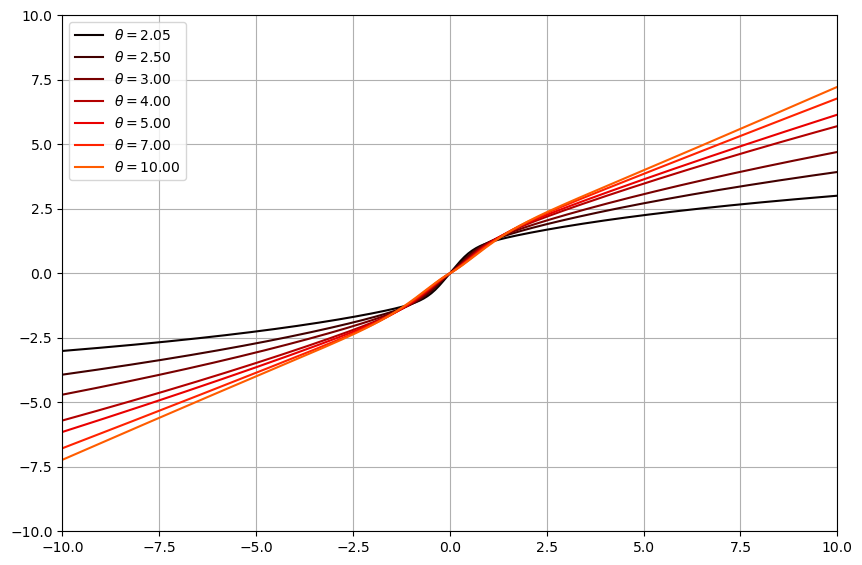

In [18]:
tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations[theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = build_color({'act_function': 'weibull', 'act_theta': theta}))

plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)

(-3.0, 3.0)

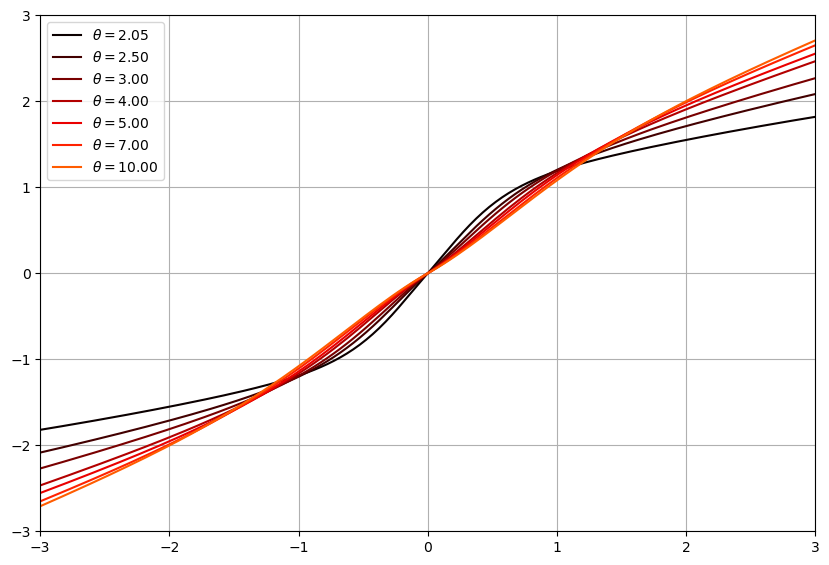

In [5]:
tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations[theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = build_color({'act_function': 'weibull', 'act_theta': theta}))

plt.legend()
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-3, 3)

In [17]:
# Load the activation functions
dct_activations = {}
for theta in lst_theta:
    dct_load = torch.load(path_objects + 'ActFunction_theta-{:.2f}.pkl'.format(theta))
    dct_activations[theta] = dct_load['activation']